# Training (Script Compatible)

Updated code to work with Nidhir's modular scripts

In [1]:
# =============================================================================
# MODULAR XGBOOST TRAINING SCRIPT (Upgraded)
#
# This script trains models on the comprehensive master feature file.
# It can select:
# 1. Preoperative features only
# 2. Waveform features only (all or a subset)
# 3. A combination of preoperative and waveform features
#
# It retains all HPO, caching, evaluation, and SHAP logic.
# =============================================================================

# --- Cell 1: Imports and Setup -----------------------------------------------
import time
import logging
from pathlib import Path
import os
import sys
import ast

import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from xgboost.callback import EarlyStopping
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(levelname)s — %(message)s",
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("--- Libraries imported and logging configured ---")


# --- Cell 2: Configuration and Paths -----------------------------------------
N_TRIALS = 100 # Number of HPO trials
N_SPLITS = 5   # Number of folds for cross-validation
RANDOM_STATE = 42

# --- HPO Caching ---
USE_HPO_CACHING = True
FORCE_HPO_RERUN = False

# --- Path Configuration ---
try:
    PROJECT_ROOT = Path.cwd().parent
    PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
except Exception as e:
    print(f"Error setting up paths: {e}")
    print("Please ensure you are running this from a subdirectory of your project root.")
    sys.exit(1)


# --- MODULAR TRAINING SETUP ---
# This is the master "wide" file created by the wrangler script
MASTER_WIDE_FILE = PROCESSED_DIR / 'aki_features_master_wide.csv'
TARGET_COLUMN = "aki_label"

# Waveform prefixes (must match data_wrangler.py)
WAVEFORM_PREFIXES = ['SNUADC_PLETH', 'SNUADC_ECG_II', 'Primus_CO2', 'Primus_AWP']

# --- MODIFICATION: Define continuous preop features ---
# This list contains ONLY the continuous variables to be used for 'baseline' models
# This list MUST match the `CONTINUOUS_COLS` from `data_wrangler.py`
CONTINUOUS_PREOP_COLS = [
    'age', 'bmi', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na',
    'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt',
    'preop_bun', 'preop_cr', 'preop_hco3'
]
# ---------------------------------------------------

# Define your training "modes"
# 'waveforms': None (all), [] (none), or list of prefixes
# 'preop_features': True or False
TRAINING_MODE = {
    # --- Waveform Models ---
    'pleth_only': {
        'waveforms': ['SNUADC_PLETH'],
        'preop_features': False
    },
    'ecg_only': {
        'waveforms': ['SNUADC_ECG_II'],
        'preop_features': False
    },
    'co2_only': {
        'waveforms': ['Primus_CO2'],
        'preop_features': False
    },
    'awp_only': {
        'waveforms': ['Primus_AWP'],
        'preop_features': False
    },
    'all_waveforms': {
        'waveforms': None,  # 'None' means all
        'preop_features': False
    },

    # --- Preop Baseline Models (New) ---
    'baseline_only': {
        'waveforms': [],  # Empty list means no waveforms
        'preop_features': True # This will now ONLY select from CONTINUOUS_PREOP_COLS
    },
    
    # --- Combined Models (New) ---
    'baseline_and_pleth': {
        'waveforms': ['SNUADC_PLETH'],
        'preop_features': True
    },
    'baseline_and_all_waveforms': {
        'waveforms': None, # 'None' means all waveforms
        'preop_features': True
    }
}


# --- Cell 3: Helper Functions ------------------------------------------------

def parse_hpo_params(filepath: Path) -> dict:
    """
    Parses the 'hpo_best_params.txt' file and returns the params dict.
    Uses ast.literal_eval for safe parsing of the dictionary string.
    """
    with open(filepath, 'r') as f:
        content = f.read()
    
    dict_start = content.find('{')
    dict_end = content.rfind('}') + 1
    
    if dict_start == -1 or dict_end == -1:
        raise ValueError(f"Could not find dictionary in {filepath}")
        
    dict_string = content[dict_start:dict_end]
    params = ast.literal_eval(dict_string)
    return params

def write_hpo_params(filepath: Path, params: dict, best_value: float):
    """
    Writes the HPO parameters and best score to the specified file
    in the "copy-paste ready" format.
    """
    output_string_list = ["hpo_params_xgboost = {"]
    for k, v in params.items():
        output_string_list.append(f"    '{k}': {v!r},")
    output_string_list.append("}")
    final_output_string = "\n".join(output_string_list)

    with open(filepath, "w") as f:
        f.write(f"# Hyperparameters saved on {time.ctime()}\n")
        f.write(f"# Best CV AUROC from HPO: {best_value:.4f}\n")
        f.write(final_output_string)
    logging.info(f"Best parameters written to {filepath}")


def objective(trial, X, y):
    """Optuna objective that uses Stratified K-Fold CV and returns mean AUROC."""
    
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    auroc_scores = []
    # --- CLASS WEIGHTS ---
    # Calculate scale_pos_weight on the full training data for this fold
    neg, pos = np.bincount(y)
    spw = np.sqrt(neg / pos) if pos > 0 else 1.0

    params = {
        "objective": "binary:logistic", "booster": "gbtree", "eval_metric": "auc",
        "tree_method": "hist", "n_jobs": -1, "random_state": RANDOM_STATE, "verbosity": 0,
        "scale_pos_weight": spw, # Apply class weights
        "n_estimators": trial.suggest_int("n_estimators", 200, 2000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.05, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "callbacks": [EarlyStopping(rounds=50)],
    }

    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        model = xgb.XGBClassifier(**params)
        model.fit(X_tr_s, y_tr, eval_set=[(X_val_s, y_val)], verbose=False)
        
        y_hat = model.predict_proba(X_val_s)[:, 1]
        auroc_scores.append(roc_auc_score(y_val, y_hat))

    return np.mean(auroc_scores)

print("--- Optuna objective function and helpers defined ---")


# --- Cell 4: Main Execution Block --------------------------------------------
def run_hpo_and_evaluate(mode_to_run: str):
    """
    Main function to run the entire HPO and evaluation pipeline
    for a single, specified training mode.
    """
    
    # --- Dynamic Path Configuration ---
    try:
        config = TRAINING_MODE[mode_to_run]
        RESULTS_SUFFIX = mode_to_run
    except KeyError:
        print(f"ERROR: Mode '{mode_to_run}' not found in TRAINING_MODE dictionary.")
        print(f"Available modes are: {list(TRAINING_MODE.keys())}")
        return

    RESULTS_DIR = PROJECT_ROOT / "results" / f"xgboost_{RESULTS_SUFFIX}"
    HPO_RESULTS_FILE = RESULTS_DIR / "hpo_best_params.txt"
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)

    logging.info(f"--- 🚀 Starting Run For Mode: {mode_to_run} ---")
    logging.info(f"Project Root set to: {PROJECT_ROOT}")
    logging.info(f"Data file set to: {MASTER_WIDE_FILE}")
    logging.info(f"Results will be saved in: {RESULTS_DIR}")

    # ---------- Load Data ----------
    csv_path = Path(MASTER_WIDE_FILE)
    try:
        df = pd.read_csv(csv_path)
        logging.info(f"Data loaded successfully from {csv_path}")
    except FileNotFoundError:
        logging.error(f"Error loading data: {csv_path} not found.")
        logging.error("Please run the 'Part 1: Comprehensive Data Wrangler' script first.")
        return

    # ---------- ** UPGRADED Dynamic Feature Selection ** ----------
    logging.info(f"Selecting features for mode: {mode_to_run}...")
    
    # 1. Get ALL available columns
    all_available_cols = [col for col in df.columns if col not in ['caseid', TARGET_COLUMN]]
    
    # 2. Separate them into preop (continuous only) vs waveform
    
    # --- MODIFICATION: Only continuous preop features are selected ---
    # `all_preop_cols` now ONLY contains the continuous variables
    all_preop_cols = []
    all_waveform_cols = []
    
    for col in all_available_cols:
        if any(col.startswith(p) for p in WAVEFORM_PREFIXES):
            all_waveform_cols.append(col)
        elif col in CONTINUOUS_PREOP_COLS: # Check against our continuous list
            all_preop_cols.append(col)
        # All other columns (e.g., one-hot encoded) are ignored
    # -----------------------------------------------------------------
            
    logging.info(f"Found {len(all_preop_cols)} continuous preop features and {len(all_waveform_cols)} total waveform features.")

    # 3. Build the final `selected_cols` list based on config
    selected_cols = []
    
    # Add preop features if requested
    if config.get('preop_features', False): # Default to False
        selected_cols.extend(all_preop_cols)
        logging.info(f"Added {len(all_preop_cols)} continuous preoperative features.")

    # Add waveform features if requested
    selected_waveforms = config.get('waveforms') # Will be None, [], or list
    
    if selected_waveforms is None:
        # 'None' means add ALL waveforms
        selected_cols.extend(all_waveform_cols)
        logging.info(f"Added all {len(all_waveform_cols)} waveform features.")
    elif selected_waveforms: # Check if list is not empty
        # Add specific waveforms
        wf_cols_to_add = []
        for prefix in selected_waveforms:
            cols_for_wf = [col for col in all_waveform_cols if col.startswith(prefix)]
            if not cols_for_wf:
                logging.warning(f"No waveform columns found with prefix: {prefix}")
            wf_cols_to_add.extend(cols_for_wf)
        
        selected_cols.extend(wf_cols_to_add)
        logging.info(f"Added {len(wf_cols_to_add)} features for prefixes: {selected_waveforms}")
    # else: if selected_waveforms is [], add no waveform features (e.g., 'baseline_only')

    # --- End of Upgraded Selection ---

    if not selected_cols:
        logging.error(f"No features were selected for mode {mode_to_run}. Check config. Aborting run.")
        return

    logging.info(f"Total features selected for model: {len(selected_cols)}")
    
    X = df[selected_cols]
    y = df[TARGET_COLUMN]

    # Handle any potential NaNs (should be covered by wrangler, but as a safeguard)
    if X.isna().any().any():
        logging.warning("NaN values detected in X. This is unexpected.")
        nan_cols = X.columns[X.isna().any()].tolist()
        logging.warning(f"Cols with NaNs: {nan_cols}")
        logging.warning("Filling with 0 (for waveforms) or -99 (for preop)...")
        
        for col in X.columns:
            if col in all_preop_cols: # all_preop_cols is now only continuous
                X[col] = X[col].fillna(-99)
            else:
                X[col] = X[col].fillna(0) # Waveform features

    # ---------- Create a final hold-out test set ----------
    X_train_main, X_test, y_train_main, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    logging.info(f"Data split into main training set ({len(y_train_main)} samples) and hold-out test set ({len(y_test)} samples).")

    # ---------- Optuna Study with CV (and Caching) ----------
    best_params = None
    logging.info("--- Checking for HPO cache ---")
    
    if USE_HPO_CACHING and not FORCE_HPO_RERUN and HPO_RESULTS_FILE.exists():
        try:
            best_params = parse_hpo_params(HPO_RESULTS_FILE)
            logging.info(f"Loaded cached HPO params from {HPO_RESULTS_FILE}")
        except Exception as e:
            logging.warning(f"Failed to load HPO cache: {e}. Re-running HPO.")
            
    if best_params is None:
        if FORCE_HPO_RERUN:
            logging.info("FORCE_HPO_RERUN is True. Forcing HPO.")
        
        logging.info(f"Starting Optuna study with {N_TRIALS} trials and {N_SPLITS}-Fold CV...")
        study = optuna.create_study(direction="maximize")
        study.optimize(
            lambda trial: objective(trial, X_train_main, y_train_main),
            n_trials=N_TRIALS,
            show_progress_bar=True,
        )
        logging.info("HPO complete.")
        
        best_params = dict(study.best_params)
        write_hpo_params(HPO_RESULTS_FILE, best_params, study.best_value)

    # ---------- Train and Evaluate Final Model on Hold-Out Set ----------
    logging.info("Training and evaluating the best model on the hold-out test set...")
    
    # --- CLASS WEIGHTS ---
    # Calculate scale_pos_weight for the final model
    neg, pos = np.bincount(y_train_main)
    best_params["scale_pos_weight"] = np.sqrt(neg / pos) if pos > 0 else 1.0
    
    final_model_params = {
        "objective": "binary:logistic", "booster": "gbtree", "tree_method": "hist",
        "n_jobs": -1, "random_state": RANDOM_STATE, **best_params,
    }

    scaler = StandardScaler()
    X_train_main_s = scaler.fit_transform(X_train_main)
    X_test_s = scaler.transform(X_test)

    final_model = xgb.XGBClassifier(**final_model_params)
    final_model.fit(X_train_main_s, y_train_main)
    
    y_test_pred_proba = final_model.predict_proba(X_test_s)[:, 1]

    # --- Find Optimal Threshold on Test Set ---
    thresholds = np.arange(0.01, 1.0, 0.01)
    f1_scores = [f1_score(y_test, y_test_pred_proba >= t) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    logging.info(f"Best threshold found on test set: {best_threshold:.2f}")
    y_test_pred_class = (y_test_pred_proba >= best_threshold).astype(int)

    # --- Calculate All Performance Metrics ---
    metrics = {
        'AUROC': roc_auc_score(y_test, y_test_pred_proba),
        'AUPRC': average_precision_score(y_test, y_test_pred_proba),
        'Accuracy': accuracy_score(y_test, y_test_pred_class),
        'Precision': precision_score(y_test, y_test_pred_class, zero_division=0),
        'Sensitivity (Recall)': recall_score(y_test, y_test_pred_class),
        'F1-Score (Maximized)': f1_score(y_test, y_test_pred_class)
    }
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_class).ravel()
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metrics_df = pd.DataFrame(metrics.items(), columns=['Metric', 'Score'])
    print("\n--- 📊 Final Model Performance on Hold-Out Test Set ---")
    print(metrics_df.round(4))
    metrics_df.to_csv(RESULTS_DIR / "final_metrics.csv", index=False)
    logging.info(f"Metrics saved to {RESULTS_DIR / 'final_metrics.csv'}")

    # --- Plot Confusion Matrix ---
    cm = confusion_matrix(y_test, y_test_pred_class)
    fig, ax = plt.subplots(figsize=(7, 6))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2. else "black")
    ax.set_xticks(np.arange(2)), ax.set_yticks(np.arange(2))
    ax.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
    ax.set_yticklabels(['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix on Hold-Out Test Data', fontsize=16, pad=20)
    plt.savefig(RESULTS_DIR / "confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.close(fig) 
    logging.info(f"Confusion matrix saved to {RESULTS_DIR / 'confusion_matrix.png'}")

    # --- SHAP Analysis ---
    logging.info("Calculating SHAP values for model explainability...")
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_test_s)
    
    logging.info("--- Saving SHAP Feature Importance (Bar Plot) ---")
    fig, ax = plt.subplots(figsize=(10, max(10, len(X.columns) * 0.5))) # Dynamic height
    shap.summary_plot(shap_values, X_test_s, feature_names=X.columns, plot_type="bar", show=False, max_display=50)
    ax.set_title("Global Feature Importance (Mean Absolute SHAP Value)", fontsize=16, pad=20)
    plt.savefig(RESULTS_DIR / "shap_summary_bar.png", dpi=300, bbox_inches='tight')
    plt.close(fig)
    logging.info(f"SHAP bar plot saved to {RESULTS_DIR / 'shap_summary_bar.png'}")

    logging.info("--- Saving SHAP Feature Importance (Dot Plot) ---")
    fig, ax = plt.subplots(figsize=(10, max(10, len(X.columns) * 0.5))) # Dynamic height
    shap.summary_plot(shap_values, X_test_s, feature_names=X.columns, plot_type="dot", show=False, max_display=50)
    ax.set_title("SHAP Summary Plot (Feature Impact)", fontsize=16, pad=20)
    plt.savefig(RESULTS_DIR / "shap_summary_dot.png", dpi=300, bbox_inches='tight')
    plt.close(fig)
    logging.info(f"SHAP dot plot saved to {RESULTS_DIR / 'shap_summary_dot.png'}")

    # --- Print Final Parameters (for easy copy-paste) ---
    output_string_list = ["{"]
    for k, v in best_params.items():
        if k != "scale_pos_weight":
            output_string_list.append(f"    '{k}': {v!r},")
    output_string_list.append("}")
    final_output_string = "\n".join(output_string_list)
    
    print("\n--- Best Hyperparameters (Copy-Paste Ready) ---")
    print(final_output_string)
    
    logging.info(f"✅ --- Pipeline complete for mode: {mode_to_run} ---")


# --- Cell 5: Run the Full Pipeline -------------------------------------------
if __name__ == "__main__":
    
    # --- Select which modes to run ---
    
    # Option 1: Run a single, specific mode
    # Comment out Option 2 if using this.
    # logging.info("--- Starting single run ---")
    # run_hpo_and_evaluate(mode_to_run='baseline_only')
    # logging.info("--- Single run complete ---")


    # Option 2: Run all modes defined in TRAINING_MODE
    # Comment out Option 1 if using this.
    logging.info("--- Starting batch run for all modes ---")
    
    all_modes = list(TRAINING_MODE.keys())
    
    for i, mode in enumerate(all_modes):
        logging.info(f"--- Running mode {i+1}/{len(all_modes)}: {mode} ---")
        try:
            run_hpo_and_evaluate(mode_to_run=mode)
        except Exception as e:
            logging.error(f"--- 💥 FAILED run for mode: {mode} ---")
            logging.error(f"Error: {e}")
        
    logging.info("--- ✅ All training runs complete ---")



2025-11-28 23:07:49,975 — INFO — --- Starting batch run for all modes ---
2025-11-28 23:07:49,977 — INFO — --- Running mode 1/8: pleth_only ---
2025-11-28 23:07:49,978 — INFO — --- 🚀 Starting Run For Mode: pleth_only ---
2025-11-28 23:07:49,979 — INFO — Project Root set to: /media/volume/catch22/projects/aki_prediction_project
2025-11-28 23:07:49,980 — INFO — Data file set to: /media/volume/catch22/projects/aki_prediction_project/data/processed/aki_features_master_wide.csv
2025-11-28 23:07:49,980 — INFO — Results will be saved in: /media/volume/catch22/projects/aki_prediction_project/results/xgboost_pleth_only
2025-11-28 23:07:50,051 — INFO — Data loaded successfully from /media/volume/catch22/projects/aki_prediction_project/data/processed/aki_features_master_wide.csv
2025-11-28 23:07:50,051 — INFO — Selecting features for mode: pleth_only...
2025-11-28 23:07:50,052 — INFO — Found 15 continuous preop features and 96 total waveform features.
2025-11-28 23:07:50,053 — INFO — Added 24 fea

--- Libraries imported and logging configured ---
--- Optuna objective function and helpers defined ---


  0%|          | 0/100 [00:00<?, ?it/s]

2025-11-28 23:08:31,919 — INFO — HPO complete.
2025-11-28 23:08:31,921 — INFO — Best parameters written to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_pleth_only/hpo_best_params.txt
2025-11-28 23:08:31,922 — INFO — Training and evaluating the best model on the hold-out test set...
2025-11-28 23:08:32,584 — INFO — Best threshold found on test set: 0.25
2025-11-28 23:08:32,599 — INFO — Metrics saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_pleth_only/final_metrics.csv



--- 📊 Final Model Performance on Hold-Out Test Set ---
                 Metric  Score
0                 AUROC 0.6089
1                 AUPRC 0.0924
2              Accuracy 0.9175
3             Precision 0.1875
4  Sensitivity (Recall) 0.1622
5  F1-Score (Maximized) 0.1739
6           Specificity 0.9602


2025-11-28 23:08:33,028 — INFO — Confusion matrix saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_pleth_only/confusion_matrix.png
2025-11-28 23:08:33,029 — INFO — Calculating SHAP values for model explainability...
2025-11-28 23:08:33,065 — INFO — --- Saving SHAP Feature Importance (Bar Plot) ---
2025-11-28 23:08:34,133 — INFO — SHAP bar plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_pleth_only/shap_summary_bar.png
2025-11-28 23:08:34,134 — INFO — --- Saving SHAP Feature Importance (Dot Plot) ---
2025-11-28 23:08:35,465 — INFO — SHAP dot plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_pleth_only/shap_summary_dot.png
2025-11-28 23:08:35,466 — INFO — ✅ --- Pipeline complete for mode: pleth_only ---
2025-11-28 23:08:35,470 — INFO — --- Running mode 2/8: ecg_only ---
2025-11-28 23:08:35,471 — INFO — --- 🚀 Starting Run For Mode: ecg_only ---
2025-11-28 23:08:35,472 — INFO — Project Root s


--- Best Hyperparameters (Copy-Paste Ready) ---
{
    'n_estimators': 200,
    'learning_rate': 0.0013146079028795042,
    'max_depth': 3,
    'subsample': 0.8468075169697571,
    'colsample_bytree': 0.9363173188443465,
    'gamma': 1.3993915478820718,
    'reg_lambda': 0.0017978510551784714,
    'reg_alpha': 4.794535567410908e-06,
}


  0%|          | 0/100 [00:00<?, ?it/s]

2025-11-28 23:10:10,677 — INFO — HPO complete.
2025-11-28 23:10:10,679 — INFO — Best parameters written to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_ecg_only/hpo_best_params.txt
2025-11-28 23:10:10,679 — INFO — Training and evaluating the best model on the hold-out test set...
2025-11-28 23:10:16,435 — INFO — Best threshold found on test set: 0.19
2025-11-28 23:10:16,450 — INFO — Metrics saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_ecg_only/final_metrics.csv



--- 📊 Final Model Performance on Hold-Out Test Set ---
                 Metric  Score
0                 AUROC 0.5324
1                 AUPRC 0.0817
2              Accuracy 0.8987
3             Precision 0.1333
4  Sensitivity (Recall) 0.1622
5  F1-Score (Maximized) 0.1463
6           Specificity 0.9404


2025-11-28 23:10:16,812 — INFO — Confusion matrix saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_ecg_only/confusion_matrix.png
2025-11-28 23:10:16,813 — INFO — Calculating SHAP values for model explainability...
2025-11-28 23:10:17,710 — INFO — --- Saving SHAP Feature Importance (Bar Plot) ---
2025-11-28 23:10:18,506 — INFO — SHAP bar plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_ecg_only/shap_summary_bar.png
2025-11-28 23:10:18,507 — INFO — --- Saving SHAP Feature Importance (Dot Plot) ---
2025-11-28 23:10:19,812 — INFO — SHAP dot plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_ecg_only/shap_summary_dot.png
2025-11-28 23:10:19,814 — INFO — ✅ --- Pipeline complete for mode: ecg_only ---
2025-11-28 23:10:19,826 — INFO — --- Running mode 3/8: co2_only ---
2025-11-28 23:10:19,827 — INFO — --- 🚀 Starting Run For Mode: co2_only ---
2025-11-28 23:10:19,828 — INFO — Project Root set to: /


--- Best Hyperparameters (Copy-Paste Ready) ---
{
    'n_estimators': 1400,
    'learning_rate': 0.003753842137770196,
    'max_depth': 8,
    'subsample': 0.8909255301988619,
    'colsample_bytree': 0.875393985532321,
    'gamma': 4.553454304439334,
    'reg_lambda': 0.00027102325640693053,
    'reg_alpha': 2.3721134560900573e-07,
}


  0%|          | 0/100 [00:00<?, ?it/s]

2025-11-28 23:11:26,215 — INFO — HPO complete.
2025-11-28 23:11:26,218 — INFO — Best parameters written to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_co2_only/hpo_best_params.txt
2025-11-28 23:11:26,220 — INFO — Training and evaluating the best model on the hold-out test set...
2025-11-28 23:11:28,072 — INFO — Best threshold found on test set: 0.24
2025-11-28 23:11:28,089 — INFO — Metrics saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_co2_only/final_metrics.csv



--- 📊 Final Model Performance on Hold-Out Test Set ---
                 Metric  Score
0                 AUROC 0.6168
1                 AUPRC 0.1181
2              Accuracy 0.9161
3             Precision 0.1818
4  Sensitivity (Recall) 0.1622
5  F1-Score (Maximized) 0.1714
6           Specificity 0.9587


2025-11-28 23:11:28,441 — INFO — Confusion matrix saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_co2_only/confusion_matrix.png
2025-11-28 23:11:28,442 — INFO — Calculating SHAP values for model explainability...
2025-11-28 23:11:28,619 — INFO — --- Saving SHAP Feature Importance (Bar Plot) ---
2025-11-28 23:11:29,425 — INFO — SHAP bar plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_co2_only/shap_summary_bar.png
2025-11-28 23:11:29,426 — INFO — --- Saving SHAP Feature Importance (Dot Plot) ---
2025-11-28 23:11:31,003 — INFO — SHAP dot plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_co2_only/shap_summary_dot.png
2025-11-28 23:11:31,005 — INFO — ✅ --- Pipeline complete for mode: co2_only ---
2025-11-28 23:11:31,012 — INFO — --- Running mode 4/8: awp_only ---
2025-11-28 23:11:31,013 — INFO — --- 🚀 Starting Run For Mode: awp_only ---
2025-11-28 23:11:31,013 — INFO — Project Root set to: /


--- Best Hyperparameters (Copy-Paste Ready) ---
{
    'n_estimators': 800,
    'learning_rate': 0.028602964141631798,
    'max_depth': 9,
    'subsample': 0.9526561977327409,
    'colsample_bytree': 0.9459029538469859,
    'gamma': 2.9198030704558517,
    'reg_lambda': 4.017105583068869e-05,
    'reg_alpha': 0.3207527278058011,
}


  0%|          | 0/100 [00:00<?, ?it/s]

2025-11-28 23:12:24,070 — INFO — HPO complete.
2025-11-28 23:12:24,073 — INFO — Best parameters written to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_awp_only/hpo_best_params.txt
2025-11-28 23:12:24,076 — INFO — Training and evaluating the best model on the hold-out test set...
2025-11-28 23:12:27,991 — INFO — Best threshold found on test set: 0.37
2025-11-28 23:12:28,005 — INFO — Metrics saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_awp_only/final_metrics.csv



--- 📊 Final Model Performance on Hold-Out Test Set ---
                 Metric  Score
0                 AUROC 0.6767
1                 AUPRC 0.2050
2              Accuracy 0.9233
3             Precision 0.2500
4  Sensitivity (Recall) 0.2162
5  F1-Score (Maximized) 0.2319
6           Specificity 0.9633


2025-11-28 23:12:28,368 — INFO — Confusion matrix saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_awp_only/confusion_matrix.png
2025-11-28 23:12:28,369 — INFO — Calculating SHAP values for model explainability...
2025-11-28 23:12:28,615 — INFO — --- Saving SHAP Feature Importance (Bar Plot) ---
2025-11-28 23:12:29,411 — INFO — SHAP bar plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_awp_only/shap_summary_bar.png
2025-11-28 23:12:29,413 — INFO — --- Saving SHAP Feature Importance (Dot Plot) ---
2025-11-28 23:12:30,703 — INFO — SHAP dot plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_awp_only/shap_summary_dot.png
2025-11-28 23:12:30,705 — INFO — ✅ --- Pipeline complete for mode: awp_only ---
2025-11-28 23:12:30,717 — INFO — --- Running mode 5/8: all_waveforms ---
2025-11-28 23:12:30,718 — INFO — --- 🚀 Starting Run For Mode: all_waveforms ---
2025-11-28 23:12:30,718 — INFO — Project Root


--- Best Hyperparameters (Copy-Paste Ready) ---
{
    'n_estimators': 1600,
    'learning_rate': 0.0035139550920969477,
    'max_depth': 3,
    'subsample': 0.8440134955951281,
    'colsample_bytree': 0.9883661164310683,
    'gamma': 4.089152256387739,
    'reg_lambda': 6.642000146474732e-08,
    'reg_alpha': 4.526798694217138e-08,
}


  0%|          | 0/100 [00:00<?, ?it/s]

2025-11-28 23:14:10,218 — INFO — HPO complete.
2025-11-28 23:14:10,219 — INFO — Best parameters written to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_all_waveforms/hpo_best_params.txt
2025-11-28 23:14:10,220 — INFO — Training and evaluating the best model on the hold-out test set...
2025-11-28 23:14:13,900 — INFO — Best threshold found on test set: 0.26
2025-11-28 23:14:13,914 — INFO — Metrics saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_all_waveforms/final_metrics.csv



--- 📊 Final Model Performance on Hold-Out Test Set ---
                 Metric  Score
0                 AUROC 0.6901
1                 AUPRC 0.1772
2              Accuracy 0.9175
3             Precision 0.2500
4  Sensitivity (Recall) 0.2703
5  F1-Score (Maximized) 0.2597
6           Specificity 0.9541


2025-11-28 23:14:14,271 — INFO — Confusion matrix saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_all_waveforms/confusion_matrix.png
2025-11-28 23:14:14,272 — INFO — Calculating SHAP values for model explainability...
2025-11-28 23:14:14,445 — INFO — --- Saving SHAP Feature Importance (Bar Plot) ---
2025-11-28 23:14:15,995 — INFO — SHAP bar plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_all_waveforms/shap_summary_bar.png
2025-11-28 23:14:15,996 — INFO — --- Saving SHAP Feature Importance (Dot Plot) ---
2025-11-28 23:14:18,535 — INFO — SHAP dot plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_all_waveforms/shap_summary_dot.png
2025-11-28 23:14:18,537 — INFO — ✅ --- Pipeline complete for mode: all_waveforms ---
2025-11-28 23:14:18,547 — INFO — --- Running mode 6/8: baseline_only ---
2025-11-28 23:14:18,549 — INFO — --- 🚀 Starting Run For Mode: baseline_only ---
2025-11-28 23:14:18,549 —


--- Best Hyperparameters (Copy-Paste Ready) ---
{
    'n_estimators': 1500,
    'learning_rate': 0.04916814516859396,
    'max_depth': 3,
    'subsample': 0.9464865896456567,
    'colsample_bytree': 0.741353793793961,
    'gamma': 3.1456395638648607,
    'reg_lambda': 9.18776741527515e-05,
    'reg_alpha': 1.7893429654247323e-05,
}


  0%|          | 0/100 [00:00<?, ?it/s]

2025-11-28 23:14:52,996 — INFO — HPO complete.
2025-11-28 23:14:52,998 — INFO — Best parameters written to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_only/hpo_best_params.txt
2025-11-28 23:14:52,998 — INFO — Training and evaluating the best model on the hold-out test set...
2025-11-28 23:14:54,812 — INFO — Best threshold found on test set: 0.14
2025-11-28 23:14:54,824 — INFO — Metrics saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_only/final_metrics.csv



--- 📊 Final Model Performance on Hold-Out Test Set ---
                 Metric  Score
0                 AUROC 0.6705
1                 AUPRC 0.1294
2              Accuracy 0.8234
3             Precision 0.1304
4  Sensitivity (Recall) 0.4054
5  F1-Score (Maximized) 0.1974
6           Specificity 0.8471


2025-11-28 23:14:55,144 — INFO — Confusion matrix saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_only/confusion_matrix.png
2025-11-28 23:14:55,144 — INFO — Calculating SHAP values for model explainability...
2025-11-28 23:14:55,507 — INFO — --- Saving SHAP Feature Importance (Bar Plot) ---
2025-11-28 23:14:55,940 — INFO — SHAP bar plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_only/shap_summary_bar.png
2025-11-28 23:14:55,941 — INFO — --- Saving SHAP Feature Importance (Dot Plot) ---
2025-11-28 23:14:56,707 — INFO — SHAP dot plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_only/shap_summary_dot.png
2025-11-28 23:14:56,709 — INFO — ✅ --- Pipeline complete for mode: baseline_only ---
2025-11-28 23:14:56,720 — INFO — --- Running mode 7/8: baseline_and_pleth ---
2025-11-28 23:14:56,721 — INFO — --- 🚀 Starting Run For Mode: baseline_and_pleth ---
2025-11-28 23:1


--- Best Hyperparameters (Copy-Paste Ready) ---
{
    'n_estimators': 1500,
    'learning_rate': 0.019735395420125614,
    'max_depth': 5,
    'subsample': 0.9007706865858349,
    'colsample_bytree': 0.8127644631720937,
    'gamma': 2.6875396602005104,
    'reg_lambda': 0.03234719312035105,
    'reg_alpha': 6.6208182056219366e-06,
}


  0%|          | 0/100 [00:00<?, ?it/s]

2025-11-28 23:16:05,365 — INFO — HPO complete.
2025-11-28 23:16:05,366 — INFO — Best parameters written to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_and_pleth/hpo_best_params.txt
2025-11-28 23:16:05,367 — INFO — Training and evaluating the best model on the hold-out test set...
2025-11-28 23:16:10,077 — INFO — Best threshold found on test set: 0.25
2025-11-28 23:16:10,091 — INFO — Metrics saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_and_pleth/final_metrics.csv



--- 📊 Final Model Performance on Hold-Out Test Set ---
                 Metric  Score
0                 AUROC 0.7254
1                 AUPRC 0.2152
2              Accuracy 0.9132
3             Precision 0.2653
4  Sensitivity (Recall) 0.3514
5  F1-Score (Maximized) 0.3023
6           Specificity 0.9450


2025-11-28 23:16:10,447 — INFO — Confusion matrix saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_and_pleth/confusion_matrix.png
2025-11-28 23:16:10,448 — INFO — Calculating SHAP values for model explainability...
2025-11-28 23:16:11,081 — INFO — --- Saving SHAP Feature Importance (Bar Plot) ---
2025-11-28 23:16:12,268 — INFO — SHAP bar plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_and_pleth/shap_summary_bar.png
2025-11-28 23:16:12,270 — INFO — --- Saving SHAP Feature Importance (Dot Plot) ---
2025-11-28 23:16:14,241 — INFO — SHAP dot plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_and_pleth/shap_summary_dot.png
2025-11-28 23:16:14,242 — INFO — ✅ --- Pipeline complete for mode: baseline_and_pleth ---
2025-11-28 23:16:14,249 — INFO — --- Running mode 8/8: baseline_and_all_waveforms ---
2025-11-28 23:16:14,250 — INFO — --- 🚀 Starting Run For Mode: baseline_a


--- Best Hyperparameters (Copy-Paste Ready) ---
{
    'n_estimators': 900,
    'learning_rate': 0.0017923975634661405,
    'max_depth': 5,
    'subsample': 0.9891733127915763,
    'colsample_bytree': 0.7466580743772037,
    'gamma': 0.9850437984287685,
    'reg_lambda': 8.832259704807133e-08,
    'reg_alpha': 0.9988693330888639,
}


  0%|          | 0/100 [00:00<?, ?it/s]

2025-11-28 23:18:45,440 — INFO — HPO complete.
2025-11-28 23:18:45,441 — INFO — Best parameters written to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_and_all_waveforms/hpo_best_params.txt
2025-11-28 23:18:45,442 — INFO — Training and evaluating the best model on the hold-out test set...
2025-11-28 23:18:48,649 — INFO — Best threshold found on test set: 0.17
2025-11-28 23:18:48,661 — INFO — Metrics saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_and_all_waveforms/final_metrics.csv



--- 📊 Final Model Performance on Hold-Out Test Set ---
                 Metric  Score
0                 AUROC 0.7897
1                 AUPRC 0.2923
2              Accuracy 0.8987
3             Precision 0.2676
4  Sensitivity (Recall) 0.5135
5  F1-Score (Maximized) 0.3519
6           Specificity 0.9205


2025-11-28 23:18:49,003 — INFO — Confusion matrix saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_and_all_waveforms/confusion_matrix.png
2025-11-28 23:18:49,004 — INFO — Calculating SHAP values for model explainability...
2025-11-28 23:18:49,105 — INFO — --- Saving SHAP Feature Importance (Bar Plot) ---
2025-11-28 23:18:50,527 — INFO — SHAP bar plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_and_all_waveforms/shap_summary_bar.png
2025-11-28 23:18:50,528 — INFO — --- Saving SHAP Feature Importance (Dot Plot) ---
2025-11-28 23:18:52,941 — INFO — SHAP dot plot saved to /media/volume/catch22/projects/aki_prediction_project/results/xgboost_baseline_and_all_waveforms/shap_summary_dot.png
2025-11-28 23:18:52,942 — INFO — ✅ --- Pipeline complete for mode: baseline_and_all_waveforms ---
2025-11-28 23:18:52,946 — INFO — --- ✅ All training runs complete ---



--- Best Hyperparameters (Copy-Paste Ready) ---
{
    'n_estimators': 700,
    'learning_rate': 0.023321600688263482,
    'max_depth': 3,
    'subsample': 0.7491245632120256,
    'colsample_bytree': 0.8269934487967335,
    'gamma': 4.92683845634022,
    'reg_lambda': 0.006034215203173112,
    'reg_alpha': 0.005981297621996347,
}


# Comparative Analysis of Results

Loading master data...
Starting comparison of 8 models...


Evaluating Models:   0%|          | 0/8 [00:00<?, ?it/s]


FINAL MODEL COMPARISON (Sorted by AUROC)


,Model,AUROC,AUPRC,F1-Score,Accuracy,Best Threshold
0,baseline_and_all_waveforms,0.789735,0.292337,0.351852,0.898698,0.170000
1,baseline_and_pleth,0.725391,0.215175,0.302326,0.913169,0.250000
2,all_waveforms,0.690140,0.177160,0.259740,0.917511,0.260000
3,awp_only,0.676667,0.205030,0.231884,0.923300,0.370000
4,baseline_only,0.670469,0.129438,0.197368,0.823444,0.140000
5,co2_only,0.616787,0.118128,0.171429,0.916064,0.240000
6,pleth_only,0.608852,0.092445,0.173913,0.917511,0.250000
7,ecg_only,0.532358,0.081655,0.146341,0.898698,0.190000


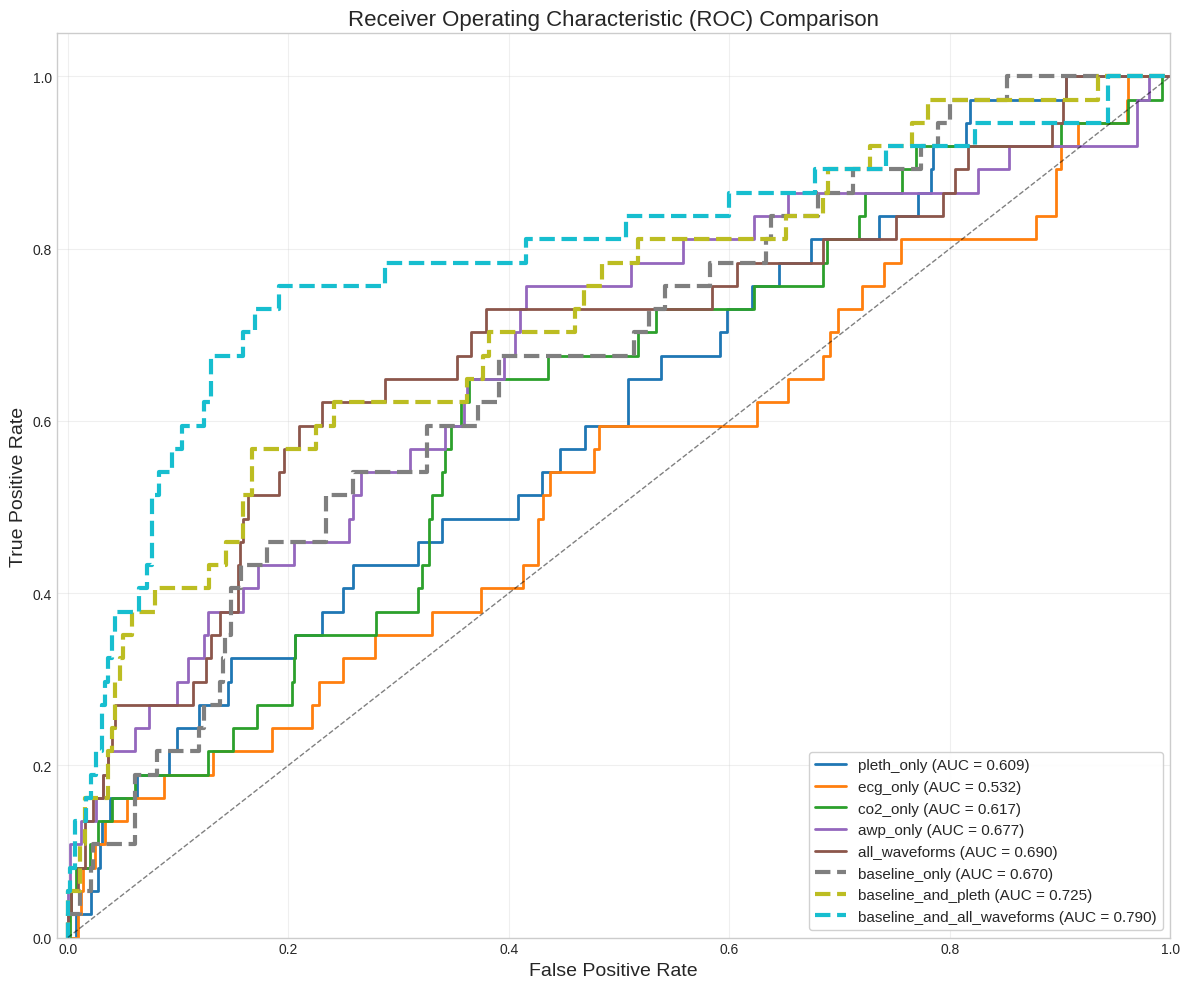

In [3]:
import time
import logging
from pathlib import Path
import ast
import sys

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    average_precision_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from tqdm.notebook import tqdm

# --- Configuration (Must match your training script) ---
RANDOM_STATE = 42
TARGET_COLUMN = "aki_label"
WAVEFORM_PREFIXES = ['SNUADC_PLETH', 'SNUADC_ECG_II', 'Primus_CO2', 'Primus_AWP']
CONTINUOUS_PREOP_COLS = [
    'age', 'bmi', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na',
    'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt',
    'preop_bun', 'preop_cr', 'preop_hco3'
]

# Path Setup
try:
    PROJECT_ROOT = Path.cwd().parent
    PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
    RESULTS_ROOT = PROJECT_ROOT / "results"
    MASTER_WIDE_FILE = PROCESSED_DIR / 'aki_features_master_wide.csv'
except Exception as e:
    print(f"Path Error: {e}")

# --- Training Modes (Copied from Training Script) ---
TRAINING_MODE = {
    'pleth_only': {'waveforms': ['SNUADC_PLETH'], 'preop_features': False},
    'ecg_only': {'waveforms': ['SNUADC_ECG_II'], 'preop_features': False},
    'co2_only': {'waveforms': ['Primus_CO2'], 'preop_features': False},
    'awp_only': {'waveforms': ['Primus_AWP'], 'preop_features': False},
    'all_waveforms': {'waveforms': None, 'preop_features': False},
    'baseline_only': {'waveforms': [], 'preop_features': True},
    'baseline_and_pleth': {'waveforms': ['SNUADC_PLETH'], 'preop_features': True},
    'baseline_and_all_waveforms': {'waveforms': None, 'preop_features': True}
}

# --- Helper Functions ---
def parse_hpo_params(filepath: Path) -> dict:
    """Parses the saved HPO dictionary from the text file."""
    if not filepath.exists():
        raise FileNotFoundError(f"Params file not found: {filepath}")
    
    with open(filepath, 'r') as f:
        content = f.read()
    
    dict_start = content.find('{')
    dict_end = content.rfind('}') + 1
    dict_string = content[dict_start:dict_end]
    return ast.literal_eval(dict_string)

def get_features_for_mode(df, mode_config):
    """Replicates the feature selection logic from the training script."""
    all_available_cols = [col for col in df.columns if col not in ['caseid', TARGET_COLUMN]]
    all_preop_cols = [col for col in all_available_cols if col in CONTINUOUS_PREOP_COLS]
    all_waveform_cols = [col for col in all_available_cols if any(col.startswith(p) for p in WAVEFORM_PREFIXES)]
    
    selected_cols = []
    
    # Add preop
    if mode_config.get('preop_features', False):
        selected_cols.extend(all_preop_cols)
        
    # Add waveforms
    selected_waveforms = mode_config.get('waveforms')
    if selected_waveforms is None: # None means All
        selected_cols.extend(all_waveform_cols)
    elif isinstance(selected_waveforms, list) and len(selected_waveforms) > 0:
        wf_cols_to_add = []
        for prefix in selected_waveforms:
            wf_cols_to_add.extend([c for c in all_waveform_cols if c.startswith(prefix)])
        selected_cols.extend(wf_cols_to_add)
        
    return selected_cols, all_preop_cols

# --- Main Execution ---

# 1. Load Data
print("Loading master data...")
df_master = pd.read_csv(MASTER_WIDE_FILE)
y_master = df_master[TARGET_COLUMN]

# 2. Define Split Indices
# We split the *indices* once to ensure every model is evaluated on the exact same patients.
indices = np.arange(len(df_master))
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, random_state=RANDOM_STATE, stratify=y_master
)

results_list = []
roc_curves = {}

print(f"Starting comparison of {len(TRAINING_MODE)} models...")

# 3. Iterate Modes
for mode_name, config in tqdm(TRAINING_MODE.items(), desc="Evaluating Models"):
    
    # A. Path to HPO params
    param_file = RESULTS_ROOT / f"xgboost_{mode_name}" / "hpo_best_params.txt"
    
    try:
        # B. Load Params
        best_params = parse_hpo_params(param_file)
        
        # C. Select Features
        selected_cols, preop_ref = get_features_for_mode(df_master, config)
        X = df_master.iloc[indices][selected_cols].copy() # Ensure alignment
        
        # D. Preprocessing (FillNA) - Replicating training script logic
        for col in X.columns:
            if col in preop_ref:
                X[col] = X[col].fillna(-99)
            else:
                X[col] = X[col].fillna(0)
                
        # E. Split into Train/Test using pre-defined indices
        X_train = X.iloc[train_idx]
        y_train = y_master.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_test = y_master.iloc[test_idx]
        
        # F. Scaling
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)
        
        # G. Train Model
        # Calculate scale_pos_weight dynamic to this fold (just to be safe/consistent)
        neg, pos = np.bincount(y_train)
        spw = np.sqrt(neg / pos) if pos > 0 else 1.0
        best_params['scale_pos_weight'] = spw
        best_params['n_jobs'] = -1
        best_params['random_state'] = RANDOM_STATE
        
        model = xgb.XGBClassifier(**best_params)
        model.fit(X_train_s, y_train, verbose=False)
        
        # H. Predictions
        y_prob = model.predict_proba(X_test_s)[:, 1]
        
        # I. Calculate Metrics
        auroc = roc_auc_score(y_test, y_prob)
        auprc = average_precision_score(y_test, y_prob)
        
        # Find best threshold (Max F1)
        thresholds = np.arange(0.01, 1.0, 0.01)
        f1_scores = [f1_score(y_test, y_prob >= t) for t in thresholds]
        best_thresh = thresholds[np.argmax(f1_scores)]
        y_pred = (y_prob >= best_thresh).astype(int)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # J. Store Results
        results_list.append({
            'Model': mode_name,
            'AUROC': auroc,
            'AUPRC': auprc,
            'F1-Score': f1,
            'Accuracy': acc,
            'Best Threshold': best_thresh
        })
        
        # Store ROC data
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_curves[mode_name] = (fpr, tpr, auroc)
        
    except FileNotFoundError:
        print(f"Skipping {mode_name}: HPO params not found. Did you run the training script?")
    except Exception as e:
        print(f"Error evaluating {mode_name}: {e}")

# --- Output 1: Performance Table ---
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='AUROC', ascending=False).reset_index(drop=True)

print("\n" + "="*50)
print("FINAL MODEL COMPARISON (Sorted by AUROC)")
print("="*50)
display(results_df.style.background_gradient(cmap='viridis', subset=['AUROC', 'AUPRC', 'F1-Score']))

# --- Output 2: Plot AUROC Lines ---
plt.figure(figsize=(12, 10))

# Colors
colors = plt.cm.tab10(np.linspace(0, 1, len(roc_curves)))

for (name, (fpr, tpr, auc_score)), color in zip(roc_curves.items(), colors):
    # Style tweak: Make baseline bold/dashed, others solid
    ls = '--' if 'baseline' in name else '-'
    lw = 3 if 'baseline' in name else 2
    
    plt.plot(fpr, tpr, color=color, linestyle=ls, linewidth=lw, 
             label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5) # Diagonal line
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Comparison', fontsize=16)
plt.legend(loc="lower right", fontsize=11, frameon=True, fancybox=True, framealpha=0.9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# AG Experimentation

In [1]:
import pandas as pd
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, average_precision_score
import numpy as np
import logging
from pathlib import Path
import sys
import os  # Added for CPU count

# Ensure logging doesn't clutter output too much for AutoGluon
logging.getLogger("autogluon").setLevel(logging.INFO)

print("--- 🚀 Starting AutoGluon Training (Mode: Baseline + All Waveforms) ---")

# 0. Configuration & Data Loading
# ==============================================================================

# --- USER CONFIG ---
CALCULATE_FEATURE_IMPORTANCE = True  # Set to True to calculate permutation importance (takes time)

# Constants
TARGET_COLUMN = "aki_label"
WAVEFORM_PREFIXES = ['SNUADC_PLETH', 'SNUADC_ECG_II', 'Primus_CO2', 'Primus_AWP']
CONTINUOUS_PREOP_COLS = [
    'age', 'bmi', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na',
    'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt',
    'preop_bun', 'preop_cr', 'preop_hco3'
]

# Path Setup
try:
    # Assuming the script is running in a subdirectory similar to the provided snippet
    PROJECT_ROOT = Path.cwd().parent
    PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
    MASTER_WIDE_FILE = PROCESSED_DIR / 'aki_features_master_wide.csv'
    
    if not MASTER_WIDE_FILE.exists():
        # Fallback: Try current directory if parent logic fails
        MASTER_WIDE_FILE = Path.cwd() / 'aki_features_master_wide.csv'
        
    print(f"Loading data from: {MASTER_WIDE_FILE}")
except Exception as e:
    print(f"Path configuration error: {e}")
    sys.exit(1)

# Load Data
try:
    df = pd.read_csv(MASTER_WIDE_FILE)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: Could not find file at {MASTER_WIDE_FILE}")
    sys.exit(1)


# 1. Feature Selection Logic (Replicating 'baseline_and_all_waveforms')
# ==============================================================================

# Collect all waveform columns present in the dataframe
waveform_cols = [col for col in df.columns if any(col.startswith(prefix) for prefix in WAVEFORM_PREFIXES)]

# Combine Preop Continuous + All Waveforms + Target
selected_features = CONTINUOUS_PREOP_COLS + waveform_cols + [TARGET_COLUMN]

# Filter df to only selected features
# We check intersection to avoid KeyErrors if some preop cols are missing
valid_selected_features = [c for c in selected_features if c in df.columns]
missing_features = set(selected_features) - set(valid_selected_features)
if missing_features:
    print(f"⚠️ Warning: The following features were not found in the dataframe: {missing_features}")

df_ag = df[valid_selected_features].copy()

# Handle NaNs: AutoGluon handles NaNs natively, but if you want to keep consistency 
# with your XGBoost script, you can fill them. 
# However, AutoGluon often learns better if we leave NaNs as NaNs (it treats missingness as information).
# We will leave them as is for this "Extreme" run to let AutoGluon decide.

print(f"Selected {len(valid_selected_features) - 1} features.")

# 2. Data Split
# ==============================================================================
# Splitting 80/20 for Training vs Final Hold-out verification
train_data, test_data = train_test_split(
    df_ag, 
    test_size=0.2, 
    random_state=42, 
    stratify=df_ag[TARGET_COLUMN]
)

print(f"Training size: {len(train_data)}, Test size: {len(test_data)}")

# --- IMBALANCE HANDLING ---
# Calculate sample weights for the training data.
# This mimics 'scale_pos_weight' by giving more weight to the minority class (1).
neg_count = (train_data[TARGET_COLUMN] == 0).sum()
pos_count = (train_data[TARGET_COLUMN] == 1).sum()
balance_ratio = neg_count / pos_count if pos_count > 0 else 1.0

print(f"--- ⚖️ Class Imbalance Handling ---")
print(f"Negative samples: {neg_count}, Positive samples: {pos_count}")
print(f"Calculated Weight Ratio: {balance_ratio:.4f} (Applied to positive class)")

# Add a 'sample_weight' column to train_data
train_data = train_data.copy()
train_data['sample_weight'] = train_data[TARGET_COLUMN].map({0: 1.0, 1: balance_ratio})

# 3. AutoGluon Training
# ==============================================================================
# Path for saving models
save_path = 'ag_models_extreme_run'

# --- Resource Configuration ---
# Calculate cores to use (Total - 2)
# Fallback to 1 if detection fails or returns < 3
total_cores = os.cpu_count() or 4
n_cores_to_use = max(1, total_cores - 2)

print(f"--- 🖥️  Resource Config ---")
print(f"CPUs Available: {total_cores}")
print(f"CPUs to Use:    {n_cores_to_use}")
print(f"GPUs to Use:    1")
print(f"--------------------------")

predictor = TabularPredictor(
    label=TARGET_COLUMN, 
    eval_metric='average_precision',  # Optimizing for AUPRC
    path=save_path,
    sample_weight='sample_weight',    # Using calculated sample weights
    verbosity=2
).fit(
    train_data,
    time_limit=3000,          # 5 Minutes as requested
    presets='extreme',       # Using 'extreme' preset per AutoGluon 1.4.0+
    
    # --- Resources ---
    num_cpus=n_cores_to_use, # Use calculated cores
    num_gpus=1,              # Enable GPU usage
    
    # TabPFN is enabled (exclusion list removed) since imports are resolved.
)

# 4. Evaluation
# ==============================================================================
print("\n--- 🏆 AutoGluon Leaderboard ---")
# Show the leaderboard evaluated on the HELD-OUT test data
lb = predictor.leaderboard(test_data, silent=True)
print(lb[['model', 'score_test', 'score_val']].head(10))

print("\n--- 📊 Final Performance on Hold-Out Test Set ---")
# Get probabilities for positive class
y_pred_proba = predictor.predict_proba(test_data).iloc[:, 1]
# Get class predictions
y_pred_class = predictor.predict(test_data)
y_true = test_data[TARGET_COLUMN]

# Metrics
metrics = {
    'AUROC': roc_auc_score(y_true, y_pred_proba),
    'AUPRC': average_precision_score(y_true, y_pred_proba), # Added AUPRC
    'Accuracy': accuracy_score(y_true, y_pred_class),
    'Precision': precision_score(y_true, y_pred_class, zero_division=0),
    'Sensitivity (Recall)': recall_score(y_true, y_pred_class),
    'F1-Score': f1_score(y_true, y_pred_class)
}

# Specificity calculation
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_class).ravel()
metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0

metrics_df = pd.DataFrame(metrics.items(), columns=['Metric', 'Score'])
print(metrics_df.round(4))

# Optional: Feature Importance
if CALCULATE_FEATURE_IMPORTANCE: 
    print("\n--- Feature Importance (Permutation Importance) ---")
    print("Calculating feature importance on test data... this may take a while.")
    try:
        fi = predictor.feature_importance(test_data)
        print(fi.head(10))
        # Optionally save to CSV
        # fi.to_csv(Path(save_path) / "feature_importance.csv")
    except Exception as e:
        print(f"Could not calculate feature importance: {e}")

Preset alias specified: 'extreme' maps to 'extreme_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.9.25
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #36~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Oct 15 15:45:17 UTC 2
CPU Count:          16
Memory Avail:       55.60 GB / 58.85 GB (94.5%)
Disk Space Avail:   884.38 GB / 983.23 GB (89.9%)
Presets specified: ['extreme']
`extreme` preset uses a dynamic portfolio based on dataset size...
	Detected data size: small (<=30000 samples), using `zeroshot_2025_tabfm` portfolio.
		Note: `zeroshot_2025_tabfm` portfolio requires a CUDA compatible GPU for best performance.
		Make sure you have all the relevant dependencies installed: `pip install autogluon.tabular[tabarena]`.
		It is strongly recommended to use a machine with 64+ GB memory and a CUDA compatible GPU with 32+ GB vRAM when using this preset. 
		This portfolio will downloa

--- 🚀 Starting AutoGluon Training (Mode: Baseline + All Waveforms) ---
Loading data from: /media/volume/catch22/projects/aki_prediction_project/data/processed/aki_features_master_wide.csv
Data loaded successfully.
Selected 111 features.
Training size: 2762, Test size: 691
--- ⚖️ Class Imbalance Handling ---
Negative samples: 2614, Positive samples: 148
Calculated Weight Ratio: 17.6622 (Applied to positive class)
--- 🖥️  Resource Config ---
CPUs Available: 16
CPUs to Use:    14
GPUs to Use:    1
--------------------------


Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ... Time limit = 3000s
AutoGluon will save models to "/media/volume/catch22/projects/aki_prediction_project/notebooks/ag_models_extreme_run"
Train Data Rows:    2762
Train Data Columns: 112
Label Column:       aki_label
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [np.int64(0), np.int64(1)]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipel

Reducing max_samples_support from 8192to 4096 due to OOM error.
Reducing max_samples_support from 4096to 2048 due to OOM error.
Reducing max_samples_support from 2048to 1024 due to OOM error.
Reducing max_samples_support from 8192to 4096 due to OOM error.
Reducing max_samples_support from 4096to 2048 due to OOM error.
Reducing max_samples_support from 2048to 1024 due to OOM error.
Reducing max_samples_support from 8192to 4096 due to OOM error.
Reducing max_samples_support from 4096to 2048 due to OOM error.
Reducing max_samples_support from 2048to 1024 due to OOM error.
Reducing max_samples_support from 8192to 4096 due to OOM error.
Reducing max_samples_support from 4096to 2048 due to OOM error.
Reducing max_samples_support from 2048to 1024 due to OOM error.
Reducing max_samples_support from 8192to 4096 due to OOM error.
Reducing max_samples_support from 4096to 2048 due to OOM error.
Reducing max_samples_support from 2048to 1024 due to OOM error.
Reducing max_samples_support from 8192to

	0.2402	 = Validation score   (average_precision)
	703.69s	 = Training   runtime
	2.29s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the 1540.31s of remaining time.
	Ensemble Weights: {'Mitra_BAG_L1': 0.353, 'TabM_r49_BAG_L1': 0.176, 'CatBoost_BAG_L1': 0.118, 'TabICL_BAG_L1': 0.118, 'LightGBM_r11_BAG_L1': 0.118, 'CatBoost_r51_BAG_L1': 0.059, 'XGBoost_r40_BAG_L1': 0.059}
	0.317	 = Validation score   (average_precision)
	0.31s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 1460.02s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 63.2 rows/s (346 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/media/volume/catch22/projects/aki_prediction_project/notebooks/ag_models_extreme_run")



--- 🏆 AutoGluon Leaderboard ---
                  model  score_test  score_val
0      TabM_r184_BAG_L1    0.345950   0.252928
1          Mitra_BAG_L1    0.324994   0.240164
2   WeightedEnsemble_L2    0.324920   0.317012
3   TabPFNv2_r94_BAG_L1    0.310391   0.220269
4       TabM_r52_BAG_L1    0.309479   0.221886
5         TabICL_BAG_L1    0.304960   0.260198
6  TabPFNv2_r181_BAG_L1    0.304810   0.253639
7   LightGBM_r21_BAG_L1    0.300067   0.191683
8   XGBoost_r171_BAG_L1    0.298374   0.172167
9  TabPFNv2_r143_BAG_L1    0.285312   0.234654

--- 📊 Final Performance on Hold-Out Test Set ---


Computing feature importance via permutation shuffling for 111 features using 691 rows with 5 shuffle sets...


                 Metric   Score
0                 AUROC  0.7677
1                 AUPRC  0.3249
2              Accuracy  0.9479
3             Precision  1.0000
4  Sensitivity (Recall)  0.0270
5              F1-Score  0.0526
6           Specificity  1.0000

--- Feature Importance (Permutation Importance) ---
Calculating feature importance on test data... this may take a while.


	4804.17s	= Expected runtime (960.83s per shuffle set)
	2185.34s	= Actual runtime (Completed 5 of 5 shuffle sets)


                                                    importance    stddev  \
Primus_AWP_SC_FluctAnal_2_rsrangefit_50_1_logi_...    0.080575  0.032101   
preop_aptt                                            0.044629  0.007595   
preop_alt                                             0.043231  0.012394   
preop_alb                                             0.042642  0.012317   
Primus_AWP_CO_trev_1_num                              0.035738  0.011126   
Primus_CO2_SB_TransitionMatrix_3ac_sumdiagcov         0.030426  0.019493   
age                                                   0.021829  0.019698   
Primus_CO2_SB_BinaryStats_mean_longstretch1           0.021726  0.013286   
Primus_AWP_FC_LocalSimple_mean1_tauresrat             0.020873  0.007696   
preop_hb                                              0.020595  0.013834   

                                                     p_value  n  p99_high  \
Primus_AWP_SC_FluctAnal_2_rsrangefit_50_1_logi_...  0.002476  5  0.146672   
preop_apt